# Miniproject 3: 7-Bit DAC

11/02/25

Drew Pang

In [4]:
import matplotlib.pyplot as plt
import numpy
import math

from util.simulation import (
    get_project_root,
    get_netlist,
    run_simulation,
    parse_data,
    light_sea_green,
    bittersweet,
    black,
    taupe_gray,
    electric_blue,
)
from util.dac import (
    calculate_inl,
    calculate_dnl,
    adjust_m2m_ladder_tb_netlist,
    adjust_bias_gen_tb_netlist,
)

# setup paths
project_root = get_project_root()
mp_root = project_root.joinpath("dac")
sim_directory = mp_root.joinpath("build")

import matplotlib.pyplot as plt
import numpy

%load_ext autoreload

In [49]:
m2m_ladder_isat_sim_directory = sim_directory.joinpath("m2m_ladder_isat")
m2m_ladder_isat_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_isat_tb.sch")

m2m_ladder_isat_netlist = get_netlist(
    schematic=m2m_ladder_isat_tb_schematic, output=m2m_ladder_isat_sim_directory
)

m2m_ladder_isat_data_file = run_simulation(
    netlist=m2m_ladder_isat_netlist, output=m2m_ladder_isat_sim_directory
)


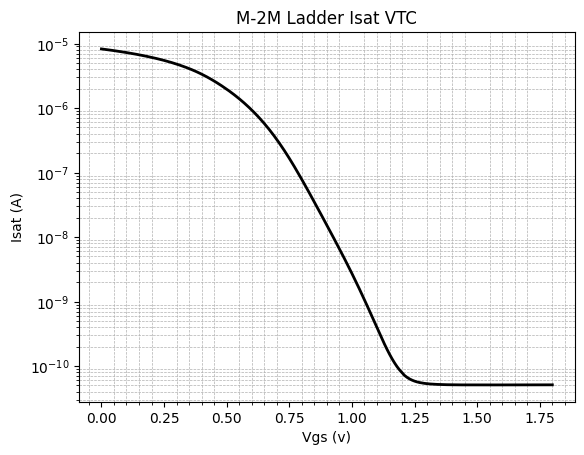

In [50]:
m2m_ladder_isat_data, _ = parse_data(m2m_ladder_isat_data_file)

plt.figure()
plt.title("M-2M Ladder Isat VTC")
plt.xlabel("Vgs (v)")
plt.ylabel("Isat (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.semilogy(
    m2m_ladder_isat_data["v-sweep"],
    m2m_ladder_isat_data["i(Vout)"],
    color=black,
    linewidth=2,
)


### M-2M Ladder Optimization

Testing current 2.19840108e-07, gate_voltage 0.73


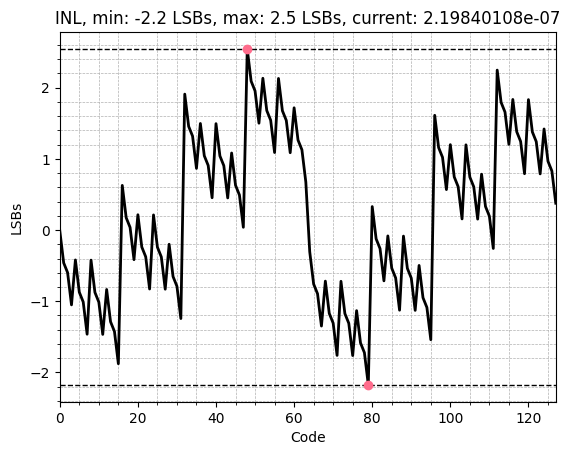

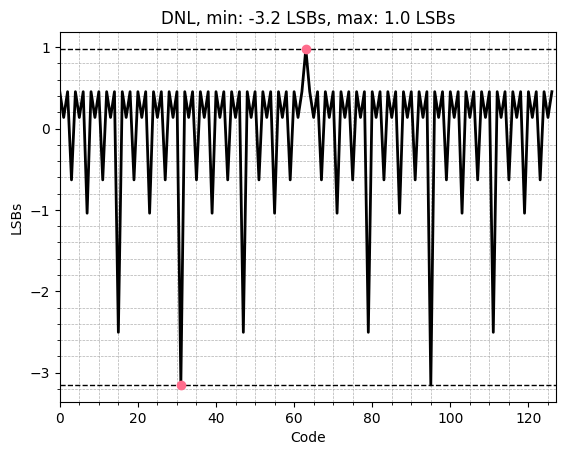

In [52]:
inl_ranges = []
dnl_ranges = []
bias_currents = []
gate_voltages = []

index = 0

for input_current, gate_voltage in zip(m2m_ladder_isat_data["i(Vout)"], m2m_ladder_isat_data["v-sweep"]):
  if (gate_voltage == 0.73):
    # input_current = 1.07750949e-6
    # gate_voltage = 0.61
    print(f"Testing current {input_current}, gate_voltage {gate_voltage}")

    m2m_ladder_sim_directory = sim_directory.joinpath("m2m_ladder")
    m2m_ladder_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_tb.sch")

    m2m_ladder_netlist = get_netlist(
        schematic=m2m_ladder_tb_schematic, output=m2m_ladder_sim_directory
    )

    adjust_m2m_ladder_tb_netlist(
        file=m2m_ladder_netlist, i_in=input_current, v_gate=gate_voltage
    )

    m2m_ladder_data = run_simulation(
        netlist=m2m_ladder_netlist, output=m2m_ladder_sim_directory
    )

    min_inl, max_inl = calculate_inl(file=m2m_ladder_data, input_current=input_current)
    min_dnl, max_dnl = calculate_dnl(file=m2m_ladder_data, input_current=input_current)

    inl_ranges.append(max_inl - min_inl)
    dnl_ranges.append(max_dnl - min_dnl)
    bias_currents.append(input_current)
    gate_voltages.append(gate_voltage)
  
  index+=1




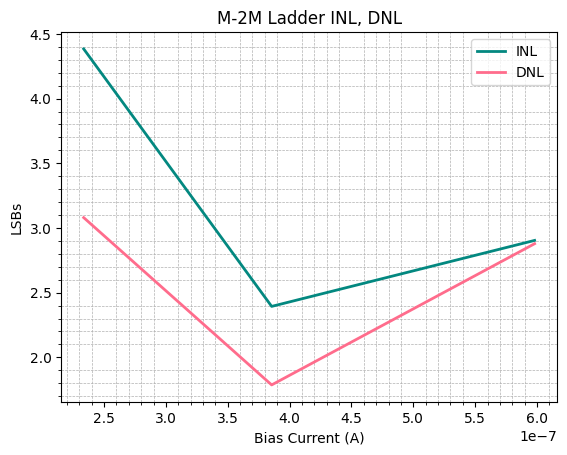

In [ ]:
plt.figure()
plt.title("M-2M Ladder INL, DNL")
plt.xlabel("Bias Current (A)")
plt.ylabel("LSBs")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    bias_currents,
    inl_ranges,
    color=light_sea_green,
    linewidth=2,
)
plt.plot(
    bias_currents,
    dnl_ranges,
    color=bittersweet,
    linewidth=2,
)
plt.legend(["INL", "DNL"])

In [74]:
%autoreload 2

# setup paths
project_root = get_project_root()
mp_root = project_root.joinpath("dac")
sim_directory = mp_root.joinpath("build")

bias_gen_sim_directory = sim_directory.joinpath("bias_gen")
bias_gen_tb_schematic = mp_root.joinpath("schematic/bias_gen_tb.sch")

bias_gen_netlist = get_netlist(
    schematic=bias_gen_tb_schematic, output=bias_gen_sim_directory
)

target_vbp = 0.73

# candidate_resistors = [100 * 1.2**index for index in range(0, 45)]
# candidate_resistors = [100, 1000, 10000, 100000, 1000000]
# candidate_resistors = [9000 + 500 * index for index in range(5)]
candidate_resistors = [300e3 + 10e3 * index for index in range(0,10)]
nmos_bias_voltage = []
pmos_bias_voltage = []

for resistor in candidate_resistors:
    adjust_bias_gen_tb_netlist(file=bias_gen_netlist, u_w=2, u_l=6, mult=2, res=resistor)

    bias_gen_data_file = run_simulation(
        netlist=bias_gen_netlist, output=bias_gen_sim_directory
    )
    bias_gen_data, _ = parse_data(bias_gen_data_file)
    nmos_bias_voltage.append(bias_gen_data["v(vbn)"][-1])
    pmos_bias_voltage.append(bias_gen_data["v(vbp)"][-1])


In [66]:
input_current = (2.1984e-7)/2

# bias gen degeneration resistor
Ut = 25.86e-3 # volts
Ib = input_current
M = 3 # degenerated mosfet strength
Is = 700e-9 # amps, specific current typ.
Vt0 = 700e-3 # volts, threshold voltage
k = 0.6 # unitless, typ.

R = (2 * Ut * math.log(math.e**(math.sqrt((3*Ib)/Is)) - 1) - 2 * Ut * math.log(math.e**(math.sqrt((3*Ib)/(M*Is)))-1)) / Ib
print(R)


332833.7185116054


Resistor, NMOS preferred: 380000.0, voltage: 0.730992493


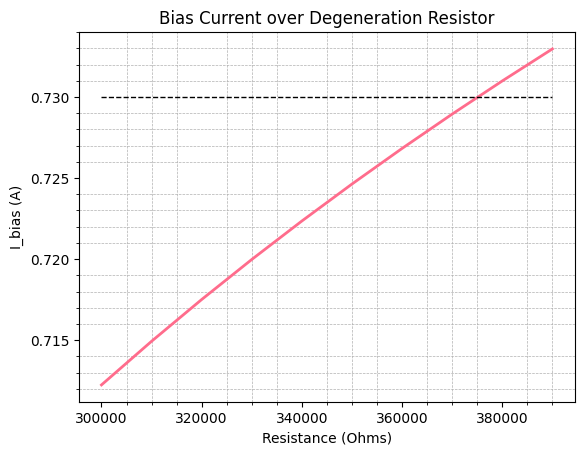

In [83]:
ladder_pmos_bias_index = numpy.argmin(numpy.abs(numpy.array(pmos_bias_voltage)-target_vbp))
# ladder_pmos_bias_index = numpy.argmin(numpy.abs(numpy.array(pmos_bias_currents)-input_current))

print(
    f"Resistor, NMOS preferred: {candidate_resistors[ladder_pmos_bias_index]}, voltage: {pmos_bias_voltage[ladder_pmos_bias_index]}"
)
# print(
#     f"Resistor, PMOS preferred: {candidate_resistors[ladder_pmos_bias_index]}, current: {pmos_bias_currents[ladder_pmos_bias_index]}"
# )

plt.figure()
plt.title("Bias Current over Degeneration Resistor")
plt.xlabel("Resistance (Ohms)")
plt.ylabel("I_bias (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
# plt.plot(
#     candidate_resistors,
#     nmos_bias_currents,
#     color=light_sea_green,
#     linewidth=2,
# )
plt.plot(
    candidate_resistors,
    pmos_bias_voltage,
    color=bittersweet,
    linewidth=2,
)
# plt.legend(["NMOS", "PMOS"])
plt.hlines(target_vbp, candidate_resistors[0], candidate_resistors[-1], linestyle="--", linewidth=1, color=black)

(-3.0034575310525105, 0.48243362398639533)

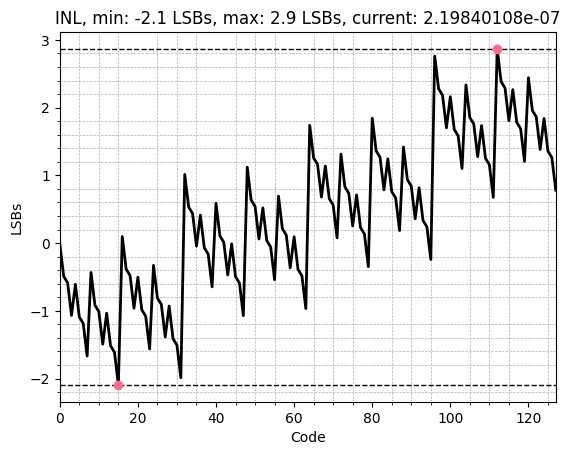

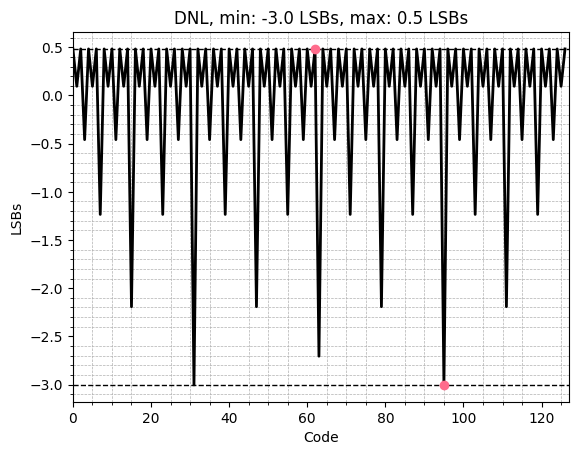

In [46]:
m2m_ladder_biased_sim_directory = sim_directory.joinpath("m2m_ladder_biased")
m2m_ladder_biased_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_biased_tb.sch")

m2m_ladder_biased_netlist = get_netlist(
    schematic=m2m_ladder_biased_tb_schematic, output=m2m_ladder_biased_sim_directory
)

m2m_ladder_biased_data = run_simulation(
    netlist=m2m_ladder_biased_netlist, output=m2m_ladder_biased_sim_directory
)
input_current = 2.19840108e-07
calculate_inl(file=m2m_ladder_biased_data, input_current=input_current)
calculate_dnl(file=m2m_ladder_biased_data, input_current=input_current)

# difference

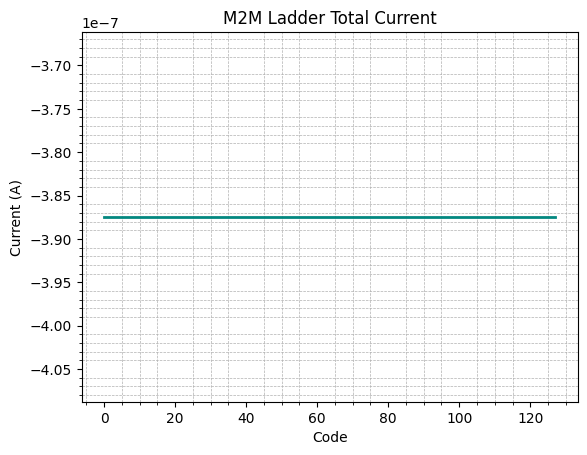

In [74]:
data, _ = parse_data(m2m_ladder_biased_data)

plt.figure()
plt.title("M2M Ladder Total Current")
plt.xlabel("Code")
plt.ylabel("Current (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    data["i(V3)"],
    color=light_sea_green,
    linewidth=2,
)

(-2.712305476123584, 0.45896273647754926)

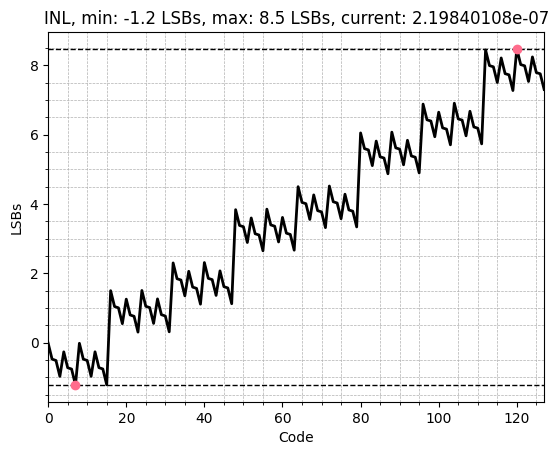

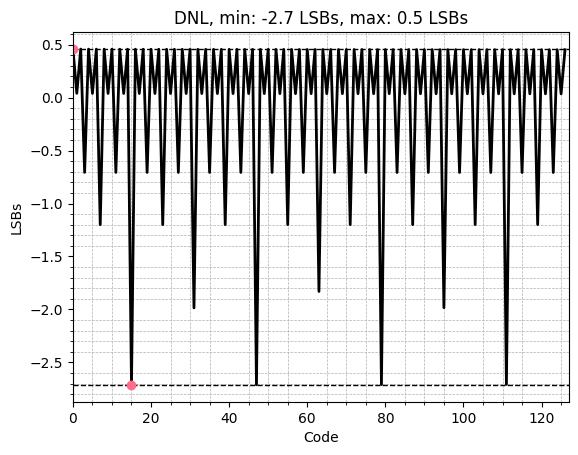

In [79]:
m2m_ladder_pseudo_biased_mirrored_sim_directory = sim_directory.joinpath("m2m_ladder_pseudo_biased_mirrored")
m2m_ladder_pseudo_biased_mirrored_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_pseudo_biased_mirrored_tb.sch")

m2m_ladder_psuedo_biased_mirrored_netlist = get_netlist(
    schematic=m2m_ladder_pseudo_biased_mirrored_tb_schematic, output=m2m_ladder_pseudo_biased_mirrored_sim_directory
)

m2m_ladder_psuedo_biased_mirrored_data = run_simulation(
    netlist=m2m_ladder_psuedo_biased_mirrored_netlist, output=m2m_ladder_pseudo_biased_mirrored_sim_directory
)
input_current = 2.19840108e-07

calculate_inl(file=m2m_ladder_psuedo_biased_mirrored_data, input_current=input_current)
calculate_dnl(file=m2m_ladder_psuedo_biased_mirrored_data, input_current=input_current)

In [87]:
m2m_ladder_biased_mirrored_sim_directory = sim_directory.joinpath("m2m_ladder_biased_mirrored")
m2m_ladder_biased_mirrored_tb_schematic = mp_root.joinpath("schematic/m2m_ladder_biased_mirrored_tb.sch")

m2m_ladder_biased_mirrored_netlist = get_netlist(
    schematic=m2m_ladder_biased_mirrored_tb_schematic, output=m2m_ladder_biased_mirrored_sim_directory
)

m2m_ladder_biased_mirrored_data = run_simulation(
    netlist=m2m_ladder_biased_mirrored_netlist, output=m2m_ladder_biased_mirrored_sim_directory
)


(-3.144389663906374, 0.5866357174509629)

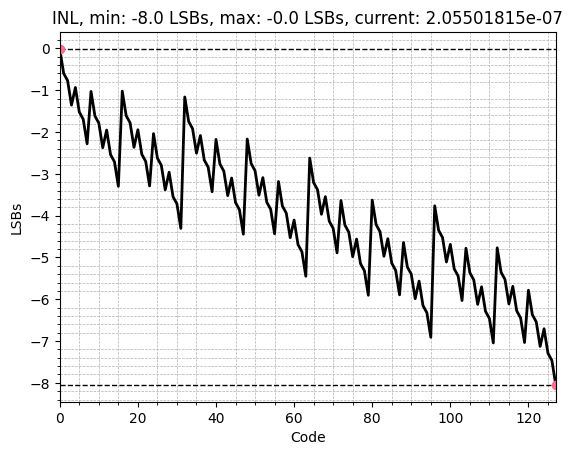

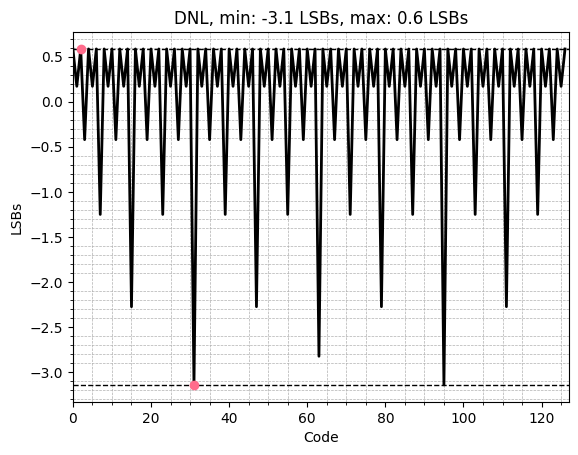

In [88]:
# input_current = 2.19840108e-07
input_current = 2.05501815e-07

calculate_inl(file=m2m_ladder_biased_mirrored_data, input_current=input_current)
calculate_dnl(file=m2m_ladder_biased_mirrored_data, input_current=input_current)

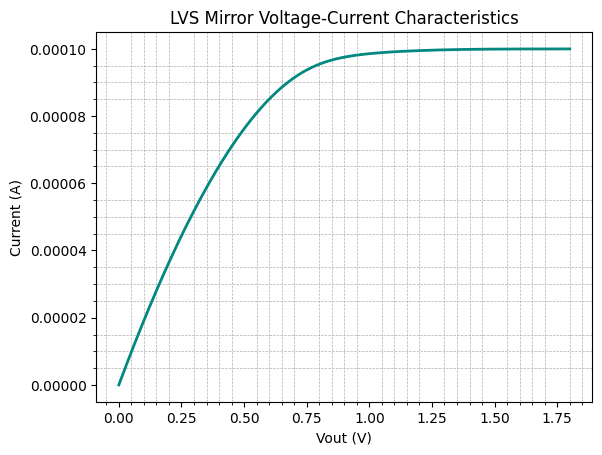

In [ ]:
lvs_mirror_sim_directory = sim_directory.joinpath("lvs_mirror")
lvs_mirror_tb_schematic = mp_root.joinpath("schematic/lvs_mirror_tb.sch")

lvs_mirror_netlist = get_netlist(
    schematic=lvs_mirror_tb_schematic, output=lvs_mirror_sim_directory
)

lvs_mirror_data = run_simulation(
    netlist=lvs_mirror_netlist, output=lvs_mirror_sim_directory
)

data, _ = parse_data(lvs_mirror_data)

plt.figure()
plt.title("LVS Mirror Voltage-Current Characteristics")
plt.xlabel("Vout (V)")
plt.ylabel("Current (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    data["i-sweep"],
    data["i(Vout)"],
    color=light_sea_green,
    linewidth=2,
)

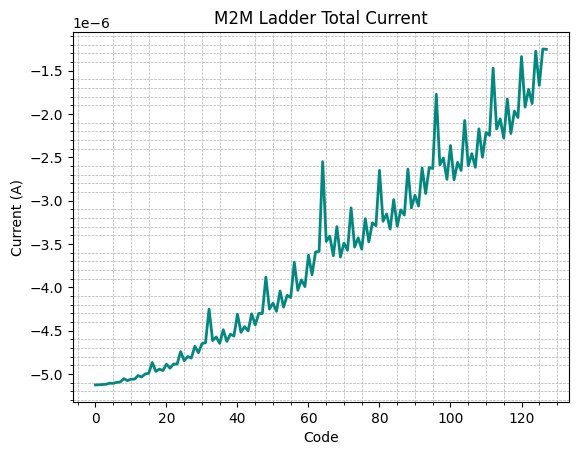

In [10]:
data, _ = parse_data(m2m_ladder_biased_mirrored_data)

plt.figure()
plt.title("M2M Ladder Total Current")
plt.xlabel("Code")
plt.ylabel("Current (A)")
plt.grid(which="minor", linestyle="--", linewidth=0.5)
plt.minorticks_on()
plt.plot(
    data["i(V3)"],
    color=light_sea_green,
    linewidth=2,
)

In [9]:
current_divider_sim_directory = sim_directory.joinpath("current_divider")
current_divider_tb_schematic = mp_root.joinpath("schematic/current_divider_tb.sch")

current_divider_netlist = get_netlist(
    schematic=current_divider_tb_schematic, output=current_divider_sim_directory
)

current_divider_data = run_simulation(
    netlist=current_divider_netlist, output=current_divider_sim_directory
)

# data, _ = parse_data(current_divider_data)

# plt.figure()
# plt.title("LVS Mirror Voltage-Current Characteristics")
# plt.xlabel("Vout (V)")
# plt.ylabel("Current (A)")
# plt.grid(which="minor", linestyle="--", linewidth=0.5)
# plt.minorticks_on()
# plt.plot(
#     data["v-sweep"],
#     data["i(Vout)"],
#     color=light_sea_green,
#     linewidth=2,
# )